In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import cv2
import numpy as np

In [100]:
from keras import backend as K
from keras.layers import Conv2D, Dropout, BatchNormalization, Input, MaxPool2D, Flatten, Dense
from keras.models import Model, load_model
from keras import metrics 

!find ./Videos/NNFL_Training_Set/ -not -name '*.avi' -delete


In [2]:
VIDEOS_DIR = './Videos/'
IMAGES_DIR = './Images/'

In [3]:
import os
classes = list(os.listdir(VIDEOS_DIR))
print(classes)

['Lifting', 'SkateBoarding', 'Swing-Bench', 'Swing-Side', 'Kicking', 'Running', 'Golf-Swing', 'Riding-Horse', 'Walking']


In [4]:
class_to_index = {}
for i in range(len(classes)):
    class_to_index[classes[i]] = i
class_to_index

{'Golf-Swing': 6,
 'Kicking': 4,
 'Lifting': 0,
 'Riding-Horse': 7,
 'Running': 5,
 'SkateBoarding': 1,
 'Swing-Bench': 2,
 'Swing-Side': 3,
 'Walking': 8}

In [5]:
videos = []
for x in classes:
    videos.append(list(os.listdir(VIDEOS_DIR+x+'/')))
print(videos)

[['005', '003', '004', '001', '002'], ['009', '005', '010', '003', '006', '004', '001', '007', '008', '002'], ['014', '009', '005', '011', '010', '003', '012', '006', '013', '004', '016', '001', '007', '008', '002', '017', '015'], ['009', '005', '011', '010', '003', '006', '004', '001', '007', '008', '002'], ['014', '009', '005', '011', '010', '003', '012', '006', '013', '004', '016', '001', '007', '002', '017', '015'], ['009', '005', '010', '006', '004', '001', '007', '008', '002'], ['014', '009', '005', '011', '010', '003', '012', '006', '013', '004', '001', '007', '008', '002'], ['009', '005', '010', '003', '006', '004', '001', '007', '008', '002'], ['014', '009', '005', '011', '010', '018', '003', '012', '006', '013', '004', '016', '001', '019', '007', '008', '002', '017', '015']]


In [6]:
# Using default 10 images per second
def convert_videos_to_images(video_path, image_path):
    print(video_path)
    cap = cv2.VideoCapture(video_path)

    # Check if video opened successfully
    if (cap.isOpened()== False): 
        print("Error opening video stream or file")
    count = 0
    
    while(cap.isOpened()):
        # Capture frame-by-frame
        ret, frame = cap.read()

        if ret == True:
            count += 1
            name = "{0:0=3d}".format(count)
            cv2.imwrite(image_path+name+'.png', frame) 
        else: 
            break

    # When everything done, release the video capture object
    cap.release()

    print(count)

In [7]:
for i in range(len(classes)):
    cls = classes[i]
    for j in range(len(videos[i])):
        vid = videos[i][j]
        video_r = VIDEOS_DIR+cls+'/'+ vid +'/'
        image_r = IMAGES_DIR+cls+'/'+ vid +'/'
        filelist= list(os.listdir(video_r))
        for fichier in filelist:
            if not(fichier.endswith(".avi")):
                filelist.remove(fichier)
        assert(len(filelist) == 1)
        convert_videos_to_images(video_r+filelist[0], image_r)

./Videos/Lifting/005/3528-10_70424.avi
127
./Videos/Lifting/003/3528-6_70(2)268.avi
123
./Videos/Lifting/004/3528-6_70270.avi
122
./Videos/Lifting/001/3528-8_70514.avi
113
./Videos/Lifting/002/2502-2_70340.avi
111
./Videos/SkateBoarding/009/947-58108.avi
70
./Videos/SkateBoarding/005/860-2001.avi
70
./Videos/SkateBoarding/010/947-70005.avi
70
./Videos/SkateBoarding/003/711-66044.avi
70
./Videos/SkateBoarding/006/860-2729.avi
70
./Videos/SkateBoarding/004/761-39000.avi
70
./Videos/SkateBoarding/001/708-75070.avi
70
./Videos/SkateBoarding/007/860-37150.avi
70
./Videos/SkateBoarding/008/860-38064.avi
70
./Videos/SkateBoarding/002/708-77009.avi
70
./Videos/Swing-Bench/014/2527-12_70526.avi
50
./Videos/Swing-Bench/009/2527-9_70087.avi
50
./Videos/Swing-Bench/005/669-67178.avi
50
./Videos/Swing-Bench/011/2527-12_70137.avi
50
./Videos/Swing-Bench/010/2527-9_70267.avi
50
./Videos/Swing-Bench/003/669-60220.avi
50
./Videos/Swing-Bench/012/2527-12_70186.avi
50
./Videos/Swing-Bench/006/2527-5_7002

In [8]:
for i in range(len(classes)):
    cls = classes[i]
    for j in range(len(videos[i])):
        vid = videos[i][j]
        video_r = VIDEOS_DIR+cls+'/'+ vid +'/'
        image_r = IMAGES_DIR+cls+'/'+ vid +'/'
        filelist = list(os.listdir(image_r))
        if len(filelist) <= 10:
            print(image_r)

./Images/Swing-Side/005/
./Images/Swing-Side/003/


In [9]:
def build_dataset(image_size):
    X_train_images = []
    Y_train_images = []
    for i in range(len(classes)):
        cls = classes[i]
        for j in range(len(videos[i])):
            vid = videos[i][j]
            video_r = VIDEOS_DIR+cls+'/'+ vid +'/'
            image_r = IMAGES_DIR+cls+'/'+ vid +'/'
            filelist = list(os.listdir(image_r))
            #print(sorted(filelist))
            for fichier in filelist:
                if fichier.endswith(".png"):
                    image = cv2.cvtColor(cv2.imread(image_r+fichier), cv2.COLOR_BGR2RGB)
                    image = cv2.resize(image, image_size)
                    X_train_images.append(image)
                    Y_train_images.append(i)
    return X_train_images, Y_train_images

In [22]:
X_train, Y_train = build_dataset((172, 172))

In [23]:
len(Y_train)

6858

In [24]:
len(X_train)

6858

In [25]:
X_train = np.array(X_train)

In [26]:
Y_train = np.array(Y_train)

In [27]:
X_train.shape

(6858, 172, 172, 3)

In [28]:
Y_train.shape

(6858,)

In [109]:
def convert_to_one_hot(Y, C):
    Y = np.eye(C)[Y.reshape(-1)]
    return Y

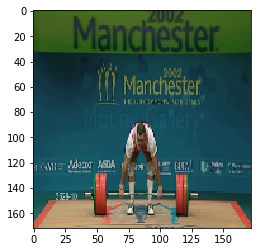

In [29]:
plt.imshow(X_train[98])

In [35]:
X_train.dtype

dtype('uint8')

In [93]:
def build_model(input_shape):
    X_input = Input(input_shape, name = "Input")
    X = BatchNormalization(name = 'BatchNorm_1')(X_input)
    X = Conv2D(16, (5, 5), strides = (2, 2), name="Conv_1a", padding="same")(X)
    X = Conv2D(32, (3, 3), name = "Conv_1b", padding="same")(X)
    X = MaxPool2D((2, 2), name = "Pool_1")(X)
    X = Conv2D(32, (3, 3), name ="Conv_2", padding = "same")(X)
    X = MaxPool2D((2, 2), name = "Pool_2")(X)
    X = Conv2D(32, (3, 3), name = "Conv_3", padding = "same")(X)
    X = MaxPool2D((2, 2), name = "Pool_3")(X)
    X = Conv2D(32, (3, 3), name = "Conv_4", padding = "same")(X)
    X = MaxPool2D((2, 2), name = "Pool_4")(X)
    X = Conv2D(8, (1, 1), name="Conv1X1")(X)
    X = Flatten()(X)
    return Model(X_input, X)

In [94]:
model = build_model((172, 172, 3))

In [96]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           (None, 172, 172, 3)       0         
_________________________________________________________________
BatchNorm_1 (BatchNormalizat (None, 172, 172, 3)       12        
_________________________________________________________________
Conv_1a (Conv2D)             (None, 86, 86, 16)        1216      
_________________________________________________________________
Conv_1b (Conv2D)             (None, 86, 86, 32)        4640      
_________________________________________________________________
Pool_1 (MaxPooling2D)        (None, 43, 43, 32)        0         
_________________________________________________________________
Conv_2 (Conv2D)              (None, 43, 43, 32)        9248      
_________________________________________________________________
Pool_2 (MaxPooling2D)        (None, 21, 21, 32)        0         
__________

In [107]:
def CNN_model(prev_model):
    X = Dense(9)(prev_model.output)
    return Model(prev_model.input, X)

In [108]:
cnn = CNN_model(model)
cnn.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           (None, 172, 172, 3)       0         
_________________________________________________________________
BatchNorm_1 (BatchNormalizat (None, 172, 172, 3)       12        
_________________________________________________________________
Conv_1a (Conv2D)             (None, 86, 86, 16)        1216      
_________________________________________________________________
Conv_1b (Conv2D)             (None, 86, 86, 32)        4640      
_________________________________________________________________
Pool_1 (MaxPooling2D)        (None, 43, 43, 32)        0         
_________________________________________________________________
Conv_2 (Conv2D)              (None, 43, 43, 32)        9248      
_________________________________________________________________
Pool_2 (MaxPooling2D)        (None, 21, 21, 32)        0         
__________

In [112]:
cnn.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

In [110]:
Y_train_one = convert_to_one_hot(Y_train, 9) 

In [106]:
Y_train

array([0, 0, 0, ..., 8, 8, 8])

In [114]:
cnn.fit(X_train, Y_train_one, batch_size=32, epochs=1)

Epoch 1/1
2304/6858 [=========>....................] - ETA: 190s - loss: 7.1999 - acc: 0.0638 - categorical_accuracy: 0.0638

KeyboardInterrupt: 